Notebook to get and clean the data of 20 minutos newspaper, about covid-19 vaccination 

In [1]:
from helpers import *

In [2]:
# Clean function in order to eliminate characters like \n or \n\n after scraping
def preprocessor(text):
    text = re.sub('\n\n', '', text)
    text = re.sub('\'','', text)
    text = re.sub('\n', '', text)
    text = re.sub('\xad', '', text)
    text = re.sub('\xa0', '', text)
    text = re.sub('\ufeff', '', text)
    text = re.sub('\u2009', '', text)
    text = re.sub('\u200b', '', text)
    
#     text = re.sub('\w*\d\w*', '', text)
    return text

In [142]:
#Install Driver
# Versión Chrome 89.0.4389.114 (Build oficial) (64 bits)
driver = webdriver.Chrome(ChromeDriverManager().install())




====== WebDriver manager ======
Current google-chrome version is 94.0.4606
Get LATEST driver version for 94.0.4606
Driver [/home/david/.wdm/drivers/chromedriver/linux64/94.0.4606.113/chromedriver] found in cache


In [5]:


# There are 551pages of vacinnes, but just 41 are from Covid: 
list_search_url =[]
list_search_url.append('https://www.20minutos.es/busqueda//?q=vacunacion+covid-19&sort_field=&category=&publishedAt%5Bfrom%5D=&publishedAt%5Buntil%5D=&articleTypes%5B0%5D=&excludedArticleTypes%5B0%5D=mam' )
for i in range(2, 552):
    list_search_url.append(f'https://www.20minutos.es/busqueda/{i}/?q=vacunacion+covid-19&sort_field=&category=&publishedAt%5Bfrom%5D=&publishedAt%5Buntil%5D=&articleTypes%5B0%5D=&excludedArticleTypes%5B0%5D=mam')


In [10]:
list_links_20minutos=[]
for i in list_search_url: 
    driver.get(i)
    time.sleep(1)
    links = driver.find_elements_by_xpath('//header/h1/a')
    for j in links: 
        list_links_20minutos.append(j.get_attribute('href'))


In [12]:
# Store the list in a document
with open("list_links_20minutos.txt", 'w') as f:
    for s in list_links_20minutos:
        f.write(str(s) + '\n')


In [4]:
with open("list_links_20minutos.txt", 'r') as f:
    list_links_20minutos = [line.rstrip('\n') for line in f]
    list_links_20minutos= list(set(list_links_20minutos))
len(list_links_20minutos)

5502

In [5]:
def get_html_20minutos(list_links):
    #Count
    extracted_articles=0 
    for i in list_links: 
        driver.get(i)
        html = driver.page_source
        tail=i.split('/')[-2]
        extracted_articles += 1
        with open(f'/home/david/Escritorio/VACTINATION_PROJECT/HTMLs/20_minutos/{tail}.txt', 'w') as f: 
            f.write(html)
        print(f'Extracted articles: {extracted_articles} of {len(list_links)}',end='\r')
        time.sleep(1)

In [1]:
get_html_20minutos(list_links_20minutos)

In [3]:
import os
list_articles_vacunacion_20minutos=[]
for filename in os.listdir("/home/david/Escritorio/VACCINATION_PROJECT/HTMLs/20_minutos/"):
    with open(os.path.join("/home/david/Escritorio/VACCINATION_PROJECT/HTMLs/20_minutos/", filename), 'r') as f:
        html_file = f.read()
    list_text=[]
    soup = BeautifulSoup(html_file, 'html.parser')
    try:
        title=soup.find(class_="title").text.strip()
    except: 
        title="error"
    try:
        author=soup.find(class_="article-author").text.strip()
    except: 
        try: 
            #Hay articulos de opinion que cambian un poco el formato
            author=soup.find(class_="opinion_author_name").text.strip()
        except: 
            author = "error"
    try:
        link=soup.find('link', rel='canonical')['href']
    except: 
        link="error"
    try:
        _div = soup.find('div', {'id':'m35-34-36'})
        results = [[i.text for i in b.find_all('li')] for b in _div.find_all('ul')]
        subheadline=' '.join(results[0])
    except:
        try: 
            subheadline=soup.find('div', {'class':'article-intro'}).text
        except: 
            subheadline="error"
    try:
        date= soup.find(class_="article-date").text
    except: 
        date="error"
    try:
        tf= soup.find(class_="article-text").find_all("p",{'class':'paragraph'})
        for p in tf:
            list_text.append(p.get_text())
        text=' '.join(list_text)
    except: 
        text= "error"
    list_articles_vacunacion_20minutos.append({'Title': title, 
                          'Subheadline':subheadline,
                          'Text':text,
                          'Authors': author, 
                          'Date': date,
                          'Link':link}) 


In [4]:
articles_20minutos = pd.DataFrame.from_dict(list_articles_vacunacion_20minutos)

# DATAFRAME CLEANING

In [8]:
#Eliminate links of videos
articles_20minutos=articles_20minutos.drop(articles_20minutos[articles_20minutos.Link.str.contains("/videos/")].index, inplace=False)
#Errors in links or Text
articles_20minutos=articles_20minutos.drop(articles_20minutos[articles_20minutos['Link']=="error"].index, inplace=False)
articles_20minutos=articles_20minutos.drop(articles_20minutos[articles_20minutos['Text']=="error"].index, inplace=False)
#some articles don't have subheadline but its fine
articles_20minutos.Link[10]

'https://www.20minutos.es/noticia/4871644/0/ceoe-colaborara-con-sanidad-en-el-control-de-la-pandemia-y-la-vacunacion-en-cantabria/'

In [9]:
# clean text
articles_20minutos['Title']=articles_20minutos['Title'].apply(preprocessor)
articles_20minutos['Text']=articles_20minutos['Text'].apply(preprocessor)

In [10]:
articles_20minutos['n_words'] = articles_20minutos.Text.apply(lambda x: len(str(x).split(' ')))
articles_20minutos.sort_values('n_words')

,Title,Subheadline,Text,Authors,Date,Link,n_words
3436,La Junta inicia mañana en la Residencia de Los...,La Junta de Castilla y León iniciará mañana mi...,Esta mañana han llegado las primeras 1.950 dos...,20M EP,29.12.2020 - 18:14h,https://www.20minutos.es/noticia/4527111/0/la-...,12
4896,Navarra ha recibido este lunes 7.020 dosis de ...,Navarra ha recibido este lunes 7.020 dosis de ...,El Ministerio de Sanidad ha entregado 55.065 a...,20M EP,15.02.2021 - 15:30h,https://www.20minutos.es/noticia/4584869/0/nav...,27
3826,"""¡Loli, que esto se acaba!"": el grito más vira...",Una joven ha compartido la reacción de un homb...,"La vacunación, pese a los problemas iniciales,...",20minutos,06.04.2021 - 14:18h,https://www.20minutos.es/gonzoo/noticia/464683...,29
3186,España acelera la vacunación: así ha crecido e...,Hasta ahora se han administrado 13.909.964 vac...,La campaña de vacunación contra la Covid-19 en...,AGENCIAS,24.04.2021 - 08:35h,https://www.20minutos.es/noticia/4671339/0/esp...,33
835,Repunte de la pandemia en España: la incidenci...,Janssen ya se administra en varias autonomías:...,La lenta cuarta ola ha dado un pequeño bandazo...,Jorge Millán,22.04.2021 - 19:23h,https://www.20minutos.es/noticia/4669444/0/la-...,37
...,...,...,...,...,...,...,...
4206,Las comunidades se blindan ante la quinta ola:...,La EMA pide estar alerta por un posible víncul...,La explosión de contagios ha obligado a las co...,EFE,09.07.2021 - 16:07h,https://www.20minutos.es/noticia/4759486/0/com...,2519
3053,El mapa de la marcha atrás en España: cada vez...,DIRECTO | Últimas noticias sobre la pandemia d...,La creciente incidencia delcoronavirus en Espa...,Elena Omedes\n \nHenar de Pedro,20.07.2021 - 23:08h,https://www.20minutos.es/noticia/4753938/0/las...,2588
32,Las comunidades autónomas se blindan frente al...,Los síntomas del covid en la quinta ola: las n...,El avance de los contagios por coronavirus y l...,Carlos Pérez Palomino\n / Agencias,27.07.2021 - 20:02h,https://www.20minutos.es/noticia/4776302/0/las...,2715
4230,Varias Comunidades adelantan la vacunación a l...,"Navarra registra una incidencia de 2.009,29 ca...","La quinta ola de covid-19 en España, caracteri...",20minutos\n GRÁFICO: HENAR DE PEDRO,07.07.2021 - 12:34h,https://www.20minutos.es/noticia/4756058/0/var...,3022


In [11]:
#only articles with words about vaccination
articles_20minutos=articles_20minutos[articles_20minutos.Text.str.contains("vacun")|articles_20minutos.Subheadline.str.contains("vacun")|articles_20minutos.Title.str.contains("vacun")]

In [12]:
import datetime
from datetime import datetime

# DATE
for index,row in articles_20minutos.iterrows(): 
    try:
        articles_20minutos['Date'][index] =datetime.strptime(articles_20minutos['Date'][index], '%d.%m.%Y - %H:%Mh').date()
    except: 
        continue

/tmp/ipykernel_272497/226841167.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_20minutos['Date'][index] =datetime.strptime(articles_20minutos['Date'][index], '%d.%m.%Y - %H:%Mh').date()


In [13]:
articles_20minutos

,Title,Subheadline,Text,Authors,Date,Link,n_words
0,Más del 70% de los gallegos a vacunar están in...,"Más de 1,9 millones de gallegos de los más de ...",Según los datos actualizados en la mañana de e...,20M EP,2021-08-01,https://www.20minutos.es/noticia/4782286/0/mas...,548
1,Los grupos plantean una lista inicial de 25 co...,La Comisión de Investigación sobre el proceso ...,"Según el calendario previsto, se ha fijado com...",20M EP,2021-02-12,https://www.20minutos.es/noticia/4581294/0/los...,535
3,Andalucía supera los seis millones de personas...,Los expertos advierten de lo que ocurrirá con ...,Andalucía ha administrado hasta el viernes 7 d...,Europa Press,2021-08-07,https://www.20minutos.es/noticia/4787680/0/and...,246
4,"La Rioja administra el 78,4% de las vacunas y ...",La Rioja ha administrado hasta este lunes 27.3...,"A su vez, en toda España se han administrado h...",20M EP,2021-03-01,https://www.20minutos.es/noticia/4604386/0/la-...,237
6,Sanidad registra la incidencia más baja desde ...,Sanidad notifica 11.358 contagios y 166 muerto...,La incidencia de la epidemia en España ha vuel...,Jorge Millán,2021-03-15,https://www.20minutos.es/noticia/4619825/0/san...,48
...,...,...,...,...,...,...,...
5444,El Parlament rechaza la comparecencia de Patri...,La Comisión de Salud ha rechazado la petición ...,La petición de comparecencia ha sido rechazada...,20M EP,2021-02-10,https://www.20minutos.es/noticia/4578700/0/el-...,132
5446,Asturias administra 75.118 dosis y cuenta con ...,El Servicio de Salud asturiano (Sespa) ha admi...,En España se han administrado un total de 2.23...,20M EP,2021-02-10,https://www.20minutos.es/noticia/4578878/0/ast...,89
5448,Satse denuncia el cierre de 2.800 camas más es...,El sindicato de Enfermería recrimina que este ...,La quinta ola de la covid-19 en España se ha d...,Lolita Belenguer,2021-07-06,https://www.20minutos.es/noticia/4754820/0/cie...,765
5449,A FONDO | Autorizado el primer ensayo clínico ...,Sanidad autoriza el primer ensayo clínico de u...,El primer ensayo en personas de una vacuna con...,20minutos\n | AGENCIAS,2021-08-11,https://www.20minutos.es/noticia/4790810/0/pri...,688


In [14]:
articles_20minutos['Newspaper']= '20 minutos'
articles_20minutos['Country']= 'Spain'

In [22]:
articles_20minutos=articles_20minutos.drop_duplicates()
articles_20minutos

,Title,Subheadline,Text,Authors,Date,Link,n_words,Newspaper,Country
0,Más del 70% de los gallegos a vacunar están in...,"Más de 1,9 millones de gallegos de los más de ...",Según los datos actualizados en la mañana de e...,20M EP,2021-08-01,https://www.20minutos.es/noticia/4782286/0/mas...,548,20 minutos,Spain
1,Los grupos plantean una lista inicial de 25 co...,La Comisión de Investigación sobre el proceso ...,"Según el calendario previsto, se ha fijado com...",20M EP,2021-02-12,https://www.20minutos.es/noticia/4581294/0/los...,535,20 minutos,Spain
3,Andalucía supera los seis millones de personas...,Los expertos advierten de lo que ocurrirá con ...,Andalucía ha administrado hasta el viernes 7 d...,Europa Press,2021-08-07,https://www.20minutos.es/noticia/4787680/0/and...,246,20 minutos,Spain
4,"La Rioja administra el 78,4% de las vacunas y ...",La Rioja ha administrado hasta este lunes 27.3...,"A su vez, en toda España se han administrado h...",20M EP,2021-03-01,https://www.20minutos.es/noticia/4604386/0/la-...,237,20 minutos,Spain
6,Sanidad registra la incidencia más baja desde ...,Sanidad notifica 11.358 contagios y 166 muerto...,La incidencia de la epidemia en España ha vuel...,Jorge Millán,2021-03-15,https://www.20minutos.es/noticia/4619825/0/san...,48,20 minutos,Spain
...,...,...,...,...,...,...,...,...,...
5444,El Parlament rechaza la comparecencia de Patri...,La Comisión de Salud ha rechazado la petición ...,La petición de comparecencia ha sido rechazada...,20M EP,2021-02-10,https://www.20minutos.es/noticia/4578700/0/el-...,132,20 minutos,Spain
5446,Asturias administra 75.118 dosis y cuenta con ...,El Servicio de Salud asturiano (Sespa) ha admi...,En España se han administrado un total de 2.23...,20M EP,2021-02-10,https://www.20minutos.es/noticia/4578878/0/ast...,89,20 minutos,Spain
5448,Satse denuncia el cierre de 2.800 camas más es...,El sindicato de Enfermería recrimina que este ...,La quinta ola de la covid-19 en España se ha d...,Lolita Belenguer,2021-07-06,https://www.20minutos.es/noticia/4754820/0/cie...,765,20 minutos,Spain
5449,A FONDO | Autorizado el primer ensayo clínico ...,Sanidad autoriza el primer ensayo clínico de u...,El primer ensayo en personas de una vacuna con...,20minutos\n | AGENCIAS,2021-08-11,https://www.20minutos.es/noticia/4790810/0/pri...,688,20 minutos,Spain


In [23]:
articles_20minutos.to_csv(r'/home/david/Escritorio/VACCINATION_PROJECT/DF_HTML_VERSION/articles_20min_last_16_11.csv', index = False)

In [24]:
df=pd.read_csv('/home/david/Escritorio/VACCINATION_PROJECT/DF_HTML_VERSION/articles_20min_last_16_11.csv')
df.sort_values('Date')

,Title,Subheadline,Text,Authors,Date,Link,n_words,Newspaper,Country
3237,Cantabria se adherirá al acuerdo marco con San...,Cantabria se adherirá al Acuerdo Marco con el ...,El Gobierno de Cantabria ha autorizado este ju...,20M EP,2020-04-02,https://www.20minutos.es/noticia/4214946/0/can...,1024,20 minutos,Spain
2276,La Junta defenderá el carné de inmunidad como ...,La Junta de Castilla y León ha rechazado que e...,"Así lo han señalado la consejera de Sanidad, V...",20M EP,2020-04-09,https://www.20minutos.es/noticia/4222390/0/la-...,477,20 minutos,Spain
373,Coronavirus.-Centro de Vacunación Internaciona...,El Centro de Vacunación Internacional de la pr...,"En un comunicado, la Subdelegación del Gobiern...",20M EP,2020-04-15,https://www.20minutos.es/noticia/4227500/0/cor...,357,20 minutos,Spain
554,"Djokovic: ""Me opongo a la vacunación y no quis...","El tenista serbio Novak Djokovic, número uno d...","""Personalmente, me opongo a la vacunación y no...",20M EP,2020-04-20,https://www.20minutos.es/deportes/noticia/4233...,154,20 minutos,Spain
2011,Casado insiste en vacunarse contra la gripe an...,"La consejera de Sanidad, Verónica Casado, ha a...","""Es necesario vacunarse contra la gripe. Ahora...",20M EP,2020-04-22,https://www.20minutos.es/noticia/4235315/0/cas...,245,20 minutos,Spain
...,...,...,...,...,...,...,...,...,...
2056,La Junta señala el calendario vacunal andaluz ...,"La delegada del Gobierno andaluz en Málaga, Pa...","En dicho calendario, aprobado el pasado miérco...",20M EP,2021-11-11,https://www.20minutos.es/noticia/4887829/0/la-...,1020,20 minutos,Spain
383,"Los vacunódromos reabren el 19, con 291.000 ga...",Los grandes centros de vacunación de Galicia v...,La reactivación de los grandes recintos de vac...,20M EP,2021-11-11,https://www.20minutos.es/noticia/4887999/0/los...,316,20 minutos,Spain
4726,La vacunación de los jóvenes de 12 a 19 años a...,Un 90% de los jóvenes de entre 12 y 19 años es...,"En el siguiente grupo de edad, de 20 a 29 años...",20M EP,2021-11-12,https://www.20minutos.es/noticia/4888374/0/la-...,190,20 minutos,Spain
1246,Más del 70% de los mayores de 70 siguen pendie...,"Según Sanidad, cerca del 27 % de las personas ...",A las puertas del invierno y con una incidenci...,EFE,2021-11-12,https://www.20minutos.es/noticia/4888333/0/mas...,947,20 minutos,Spain


# Number of articles over time

In [28]:
df_overtime=df.copy()
df_overtime.dropna(inplace=True)
df_overtime['date'] = pd.to_datetime(df_overtime['Date'])
# Set date column as index 
df_overtime = df_overtime.set_index('date')
# Count the number of articles by month
df_monthly = df_overtime.resample('M').size()

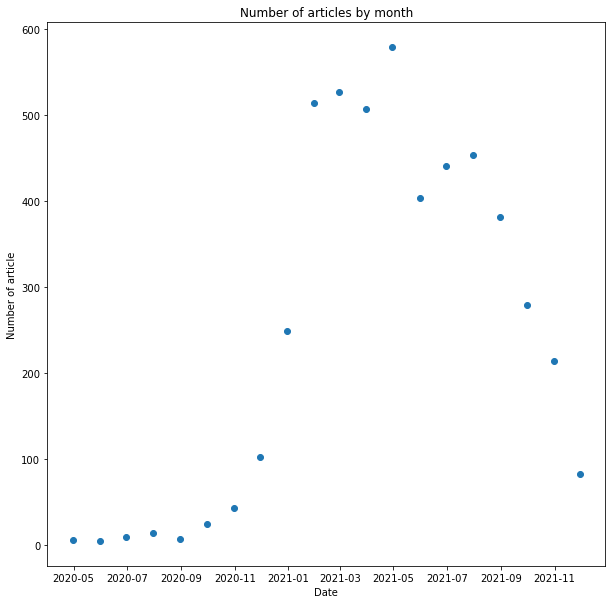

In [29]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(df_monthly.index.values,
           df_monthly.values)

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Number of article",
       title="Number of articles by month")

plt.show()

# NER

In [4]:
df_ner= ner(df.Text,"es_core_news_sm")

In [5]:
df_ner=df_ner.groupby(['Entity','Label']).size().reset_index(name='Frequency')

In [6]:
#Eliminate wrong entitites
list_wrong_entities=['Además', 'Según','Así','También','según', 'aun','habían','Asimismo','Está']
df_ner=df_ner[~df_ner.Entity.isin(list_wrong_entities)]

Text(0.5, 1.0, 'Most frequent NE PERSON')

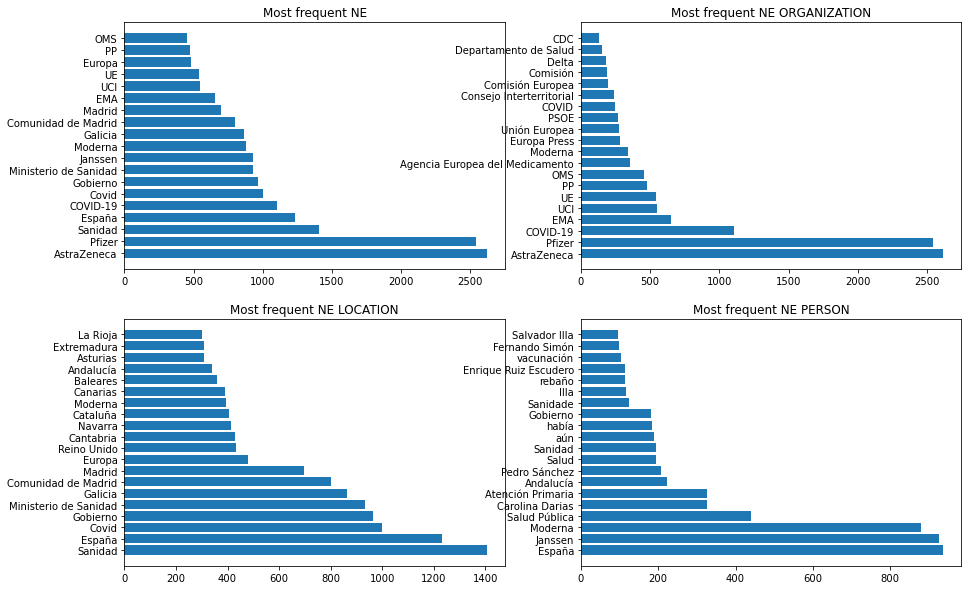

In [7]:
fig, axs = plt.subplots(2, 2,figsize=(15,10))
axs[0, 0].barh(y=df_ner.sort_values('Frequency',ascending=False).head(20)['Entity'],width=df_ner.sort_values('Frequency',ascending=False).head(20)['Frequency'])
axs[0,0].set_title('Most frequent NE')
axs[0, 1].barh(y=df_ner[df_ner['Label']=="ORG"].sort_values('Frequency',ascending=False).head(20)['Entity'], width=df_ner[df_ner['Label']=="ORG"].sort_values('Frequency',ascending=False).head(20)['Frequency'])
axs[0,1].set_title('Most frequent NE ORGANIZATION')
axs[1, 0].barh(y=df_ner[df_ner['Label']=="LOC"].sort_values('Frequency',ascending=False).head(20)['Entity'], width=df_ner[df_ner['Label']=="LOC"].sort_values('Frequency',ascending=False).head(20)['Frequency'])
axs[1,0].set_title('Most frequent NE LOCATION')
axs[1, 1].barh(y=df_ner[df_ner['Label']=="PER"].sort_values('Frequency',ascending=False).head(20)['Entity'], width=df_ner[df_ner['Label']=="PER"].sort_values('Frequency',ascending=False).head(20)['Frequency'])
axs[1,1].set_title('Most frequent NE PERSON')